# Context

Visualization of derived measures: Integrals in space and absolute frequencies.

# Imports

In [2]:
from skimage import io
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, uniform_filter
import pickle

In [3]:
import imageio
from pathlib import Path

In [4]:
from PIL import Image
import os

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

In [6]:
import matplotlib.animation
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**128

### Import our custom utility methods

In [269]:
import sys
%reload_ext autoreload
%autoreload 2
sys.path.append('../..')

from utils.visualization_tools import *
import utils.visualization_tools
from utils.data_transformations import *
import utils.data_transformations
from utils.diverse import *
import utils.diverse

In [8]:
def load_files_in_folder(folder):
    files = os.listdir(folder)
    files.sort()
    paths = [os.path.join(folder, f) for f in files]
    
    tensors = [np.load(f) for f in paths]
    return tensors, files

In [9]:
def plot_stacked(means, title="", sampling_frequency = 100, x_tick_dist=20, y_label = "", x_label = "", y_lim = None):
    fig, ax = plt.subplots(len(means), figsize=(10,10))
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

    gs = gridspec.GridSpec(len(means), 1, height_ratios=np.ones(len(means))) 

    for i, mean in enumerate(means):
        ax = plt.subplot(gs[i])
        ax.set_ylabel(y_label)
        ax.plot(mean)
        if type(y_lim) != type(None):
            ax.set_ylim(y_lim[0],y_lim[1])

        if i == len(means)-1:
            ax.set_xlabel(x_label)
            ax.set_xticks(np.arange(0, len(means[0])+10, sampling_frequency*x_tick_dist))#100 sampling freq, 20 distance of x_ticks
            ax.set_xticklabels(np.arange(0, len(means[0])+10, x_tick_dist))# +10 such that last tick is shown (300)
    plt.subplots_adjust(hspace=.0)
    plt.show()

In [216]:
derived_global_features_folder = "../../../../datasets/derived_global_features_1/"

In [217]:
source_data_folder = "../../../../datasets/source_data"

In [65]:
mask_folder = source_data_folder

# Baseline and mean of the datasets

In [116]:
files = os.listdir(source_data_folder)
files.sort()
mean_in_time = [np.nanmean(np.array(skimage.io.imread(os.path.join(source_data_folder, f))), axis=(1,2)) for f in files if ".tif" in f]

In [117]:
mean_in_time = [np.concatenate(mean_in_time[i:i+3]) for i in range(0,len(mean_in_time),3)]

Text(0.5, 0, 'frame')

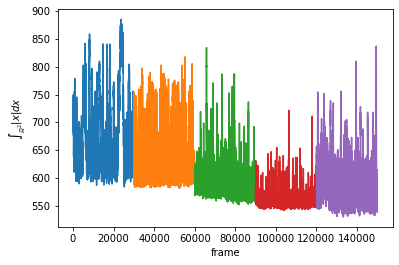

In [151]:
fig, ax = plt.subplots(1)
for i, y in enumerate(mean_in_time):
    ax.plot(np.arange(len(y))+i*len(y),y)
ax.set_ylabel(r"$\int_{\mathbb{R}^2}\left|x\right|dx$")
ax.set_xlabel("frame")

In [127]:
isoflurane = [1.8, 2, 2.2, 2.4, 2.6]

Text(0.5, 0, 'isoflurane')

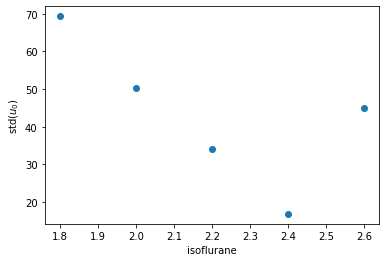

In [128]:
fig, ax = plt.subplots(1)
ax.set_ylabel("std($u_0$)")
ax.scatter(isoflurane,[np.std(x) for x in mean_in_time])
ax.set_xlabel("isoflurane")

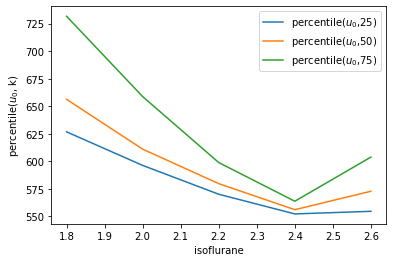

In [153]:
fig, ax = plt.subplots(1)
ax.set_ylabel("percentile($u_0$, k)")
ax.set_xlabel("isoflurane")

for perc in [25,50,75]:
    ax.plot(isoflurane,[np.percentile(x, perc) for x in mean_in_time], label = "percentile($u_0$,"+str(perc)+")")
    
ax.legend()

--> Baseline different, is the illumination the same?

--> Conditions are best comparable if local normalization is done using a common mean image

--> How should I handle this?

In [218]:
os.listdir(derived_global_features_folder)

['absolute_frequencies', 'bin_boundaries', 'spatial_integrals']

In [219]:
frequencies_folder = os.path.join(derived_global_features_folder, "absolute_frequencies")
bin_boundaries_folder = os.path.join(derived_global_features_folder, "bin_boundaries")
spatial_integrals_folder = os.path.join(derived_global_features_folder, "spatial_integrals")

In [220]:
intensity_integrals_path = os.path.join(spatial_integrals_folder,"intensity")

In [221]:
os.listdir(spatial_integrals_folder)

['temporal_energy',
 'spatial_energy',
 'intensity',
 'field_strengths',
 'total_flow']

In [222]:
#masks = [os.path.join(mask_folder, f.split(".")[0]+"_mask.png") for f in np.sort(os.listdir(intensity_integrals_path))]
#masks =  [np.array(Image.open(mask_path)) == 255 for mask_path in masks]

In [223]:
#foreground_pixels = np.nansum(masks, axis=(1,2))
#intensity_integrals = [i/j for i, j in zip(intensity_integrals, foreground_pixels)]
#framewise_mean = [i/j for i, j in zip(intensity_integrals, foreground_pixels)]

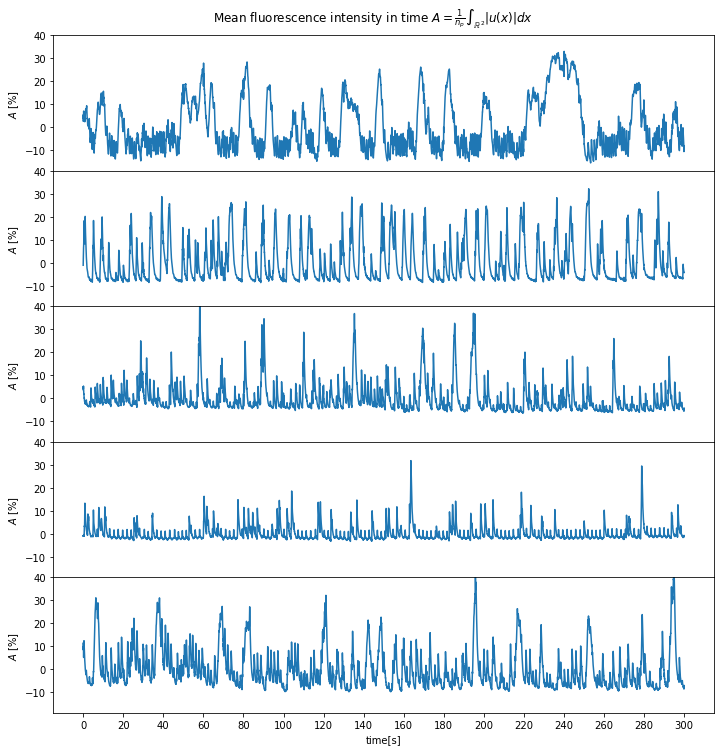

In [224]:
intensity_integrals, names = load_files_in_folder(intensity_integrals_path)
plot_stacked(intensity_integrals, x_label = "time[s]", y_lim = (-19, 40), 
             title=r"Mean fluorescence intensity in time $A=\frac{1}{n_{p}}\int_{\mathbb{R}^2}\left|u(x)\right|dx$", 
            y_label = r"$A$ [%]")

In [292]:
freqs = np.array([fourier(gaussian_filter(f, 0)) for f in intensity_integrals])

freqs[:,1,0] = 0
freqs = freqs[:,:,:1000]

In [293]:
if False:
    fig, ax = plt.subplots(2)
    x, y = sinus(hz=1, sampling_freq=100, length=20)
    x1,y1 = fourier(y)
    
    ax[0].plot(x, y)
    plt.plot(x1[:50],y1[:50])

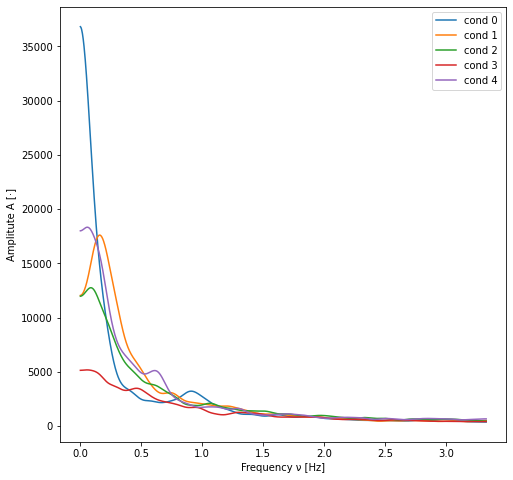

In [294]:
fig, ax = plt.subplots(1, figsize=(8,8))
for i, [x, y] in enumerate(freqs):
    #ax.set_yscale('log')
    y = gaussian_filter(y,15)
    ax.plot(x, y, label="cond "+ str(i))
    ax.set_xlabel("Frequency ν [Hz]")
    ax.set_ylabel("Amplitute A [·]")
ax.legend()

In [295]:
without_trend = [f-gaussian_filter(f, 150) for f in intensity_integrals]
freqs = np.array([fourier(gaussian_filter(f, 0)) for f in without_trend])

freqs[:,1,0] = 0
freqs = freqs[:,:,:1000]

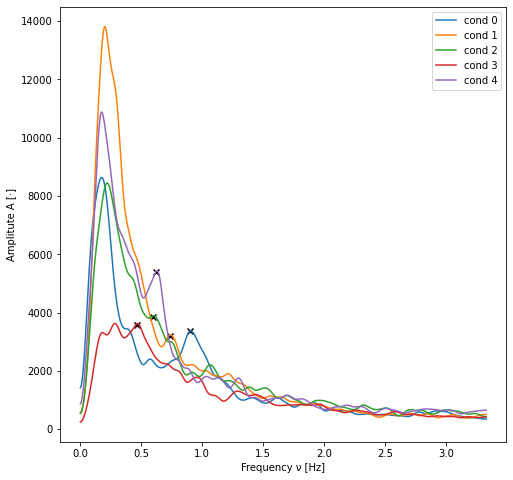

In [356]:
fig, ax = plt.subplots(1, figsize=(8,8))
for i, [x, y] in enumerate(freqs):
    #ax.set_yscale('log')
    y = gaussian_filter(y,10)
    ax.plot(x, y, label="cond "+ str(i))
    ax.set_xlabel("Frequency ν [Hz]")
    ax.set_ylabel("Amplitute A [·]")
ax.legend()

xs = [0.9, 0.735, 0.6, 0.465, 0.62]
ys = [3350, 3200, 3850, 3560, 5400]
plt.scatter(xs, ys, marker="x", c= "black")

Text(0.5, 0, 'isoflurane')

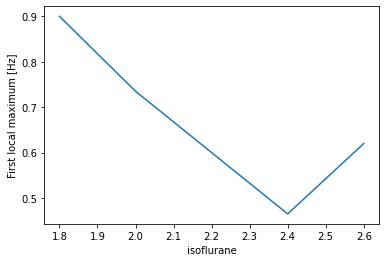

In [363]:
fig, ax = plt.subplots(1)
ax.plot(isoflurane, xs)
ax.set_ylabel("First local maximum [Hz]")
ax.set_xlabel("isoflurane")

In [365]:
if False:
    intensity_integrals, names = load_files_in_folder(intensity_integrals_path)
    plot_stacked(intensity_integrals, x_label = "time[s]", y_lim = (0, 300000), 
                 title=r"Framewise fluorescence intensity $A=\int_{\mathbb{R}^2}\left|u(x)\right|dx$", 
                y_label = r"Intensity ($A$) [%]")

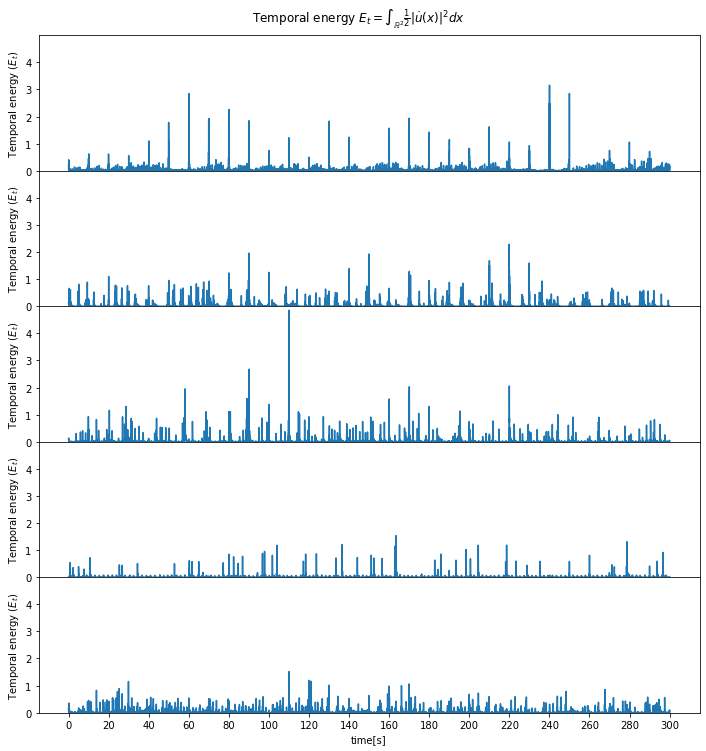

In [366]:
temporal_energy_integrals, names = load_files_in_folder(os.path.join(spatial_integrals_folder,"temporal_energy"))
plot_stacked(temporal_energy_integrals, x_label = "time[s]", y_lim = (0, 4.99), 
             title=r"Temporal energy $E_t=\int_{\mathbb{R}^2}{\frac{1}{2}\left|\dot{u}(x)\right|^2dx}$", 
            y_label = r"Temporal energy ($E_t$)")

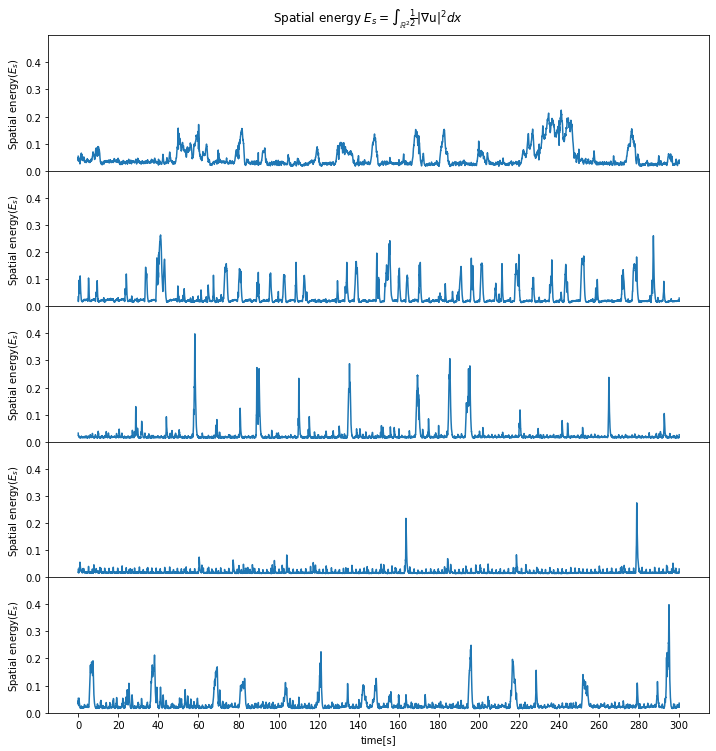

In [367]:
spatial_energy_integrals, names = load_files_in_folder(os.path.join(spatial_integrals_folder,"spatial_energy"))
plot_stacked(spatial_energy_integrals, x_label = "time[s]", y_lim = (0,0.499), 
    title=r"Spatial energy $E_s=\int_{\mathbb{R}^2}{\frac{1}{2}\left|\mathrm{\nabla u}\right|^2dx}$",
    y_label = r"Spatial energy($E_s$)")

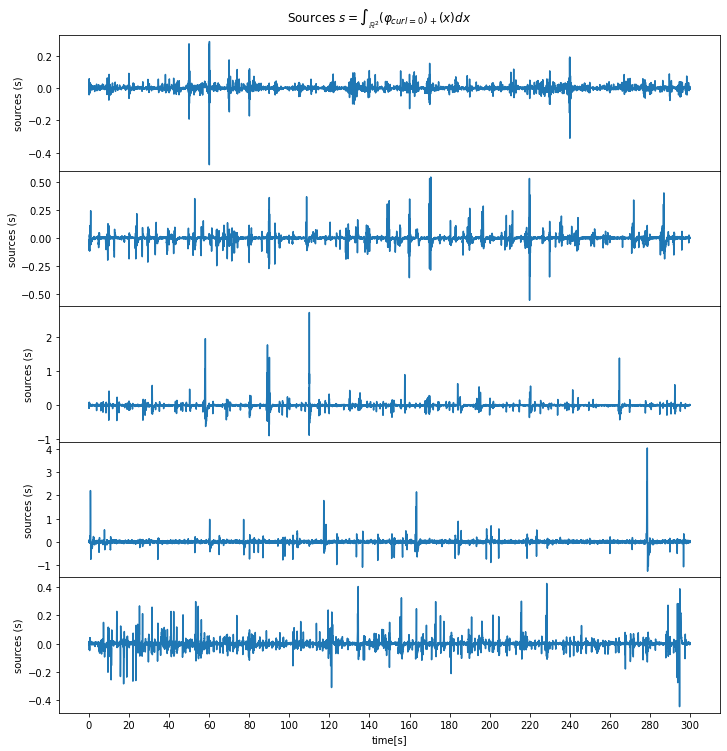

In [372]:
sources_integrals, names = load_files_in_folder(os.path.join(spatial_integrals_folder,"sources"))
plot_stacked(-np.array(sources_integrals), x_label = "time[s]",  
    title=r"Sources $s=\int_{\mathbb{R}^2}{\left(\varphi_{curl=0}\right)_+\left(x\right)dx}$",
    y_label = r"sources (s)")

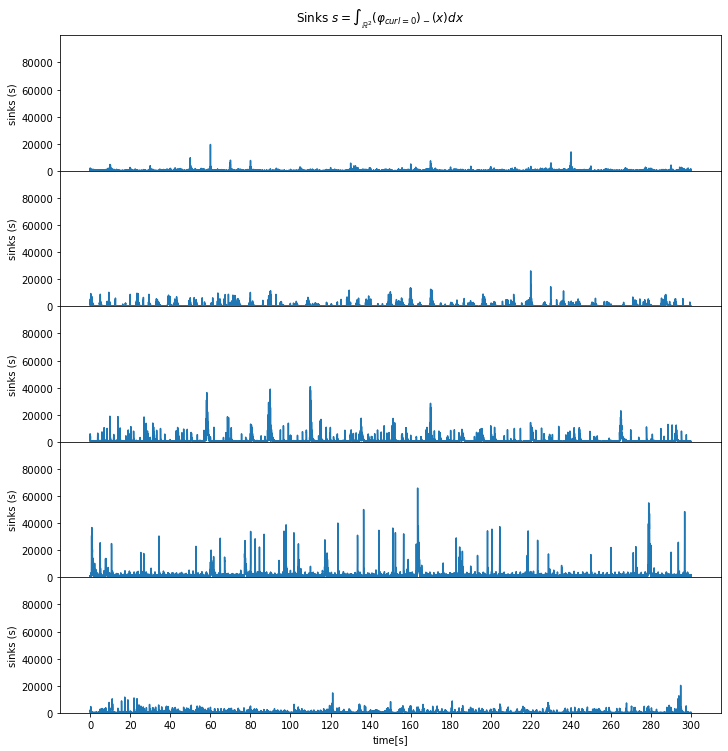

In [44]:
sinks_integrals, names = load_files_in_folder(os.path.join(spatial_integrals_folder,"sinks"))
plot_stacked(sinks_integrals, x_label = "time[s]", y_lim = (0,100000-1), 
    title=r"Sinks $s=\int_{\mathbb{R}^2}{\left(\varphi_{curl=0}\right)_-\left(x\right)dx}$",
    y_label = r"sinks (s)")

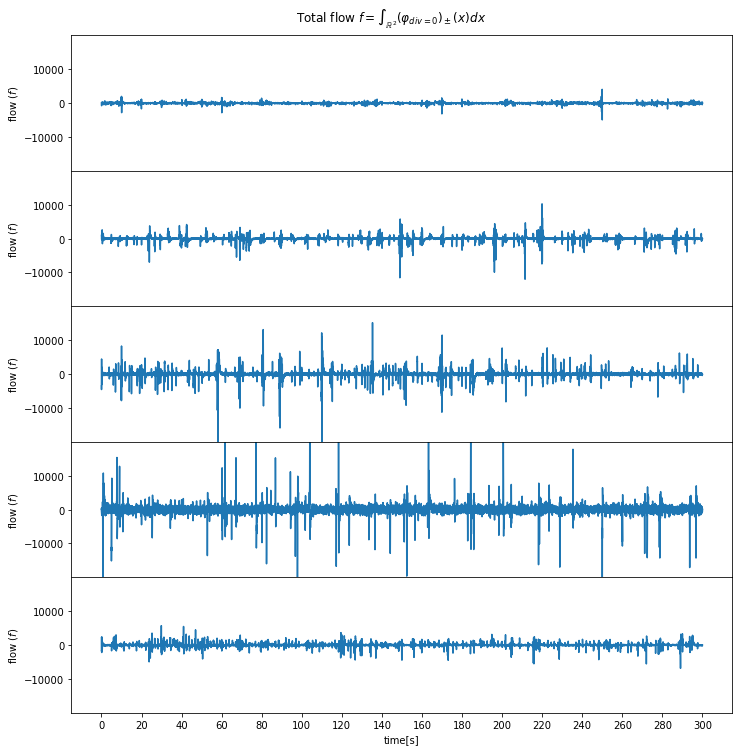

In [45]:
total_flow, names = load_files_in_folder(os.path.join(spatial_integrals_folder,"total_flow"))
plot_stacked(total_flow, x_label = "time[s]", y_lim = (-20000+1, 20000-1), 
    title=r"Total flow $f=\int_{\mathbb{R}^2}{\left(\varphi_{div=0}\right)_\pm\left(x\right)dx}$",
    y_label = r"flow $(f)$")

## Absolute frequency distributions

In [46]:
os.listdir(frequencies_folder)

['temporal_energy',
 'spatial_energy',
 'intensity',
 'field_strengths',
 'flow_frequency',
 'sources_frequency',
 'sinks_frequency']

In [189]:
def plot_frequencies(histograms, bins_of_hists, x_label="", y_label="absolute frequency", title="", logscale=True):
    fig, ax = plt.subplots(1)
    fig.suptitle(title)
    for i, [his, bins] in enumerate(zip(histograms, bins_of_hists)):
        print(".", end="")
        if logscale:
            ax.set_yscale('log')
        ax.plot(bins[:-1],his, label = "cond " + str(i))
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

    ax.legend()

.....

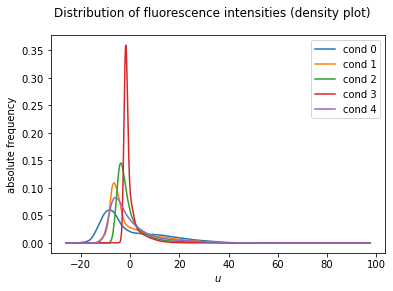

In [55]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "intensity"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "intensity"))
plot_frequencies(hists, bins, 
                 x_label=r"$u$",
                title= "Distribution of fluorescence intensities (density plot)", logscale=False)

.....

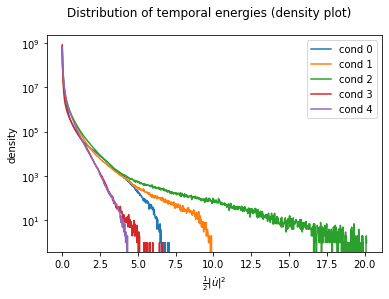

In [213]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "temporal_energy"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "temporal_energy"))
plot_frequencies(hists, bins, 
                 x_label=r"$\frac{1}{2}\left \| \dot{u} \right \|^{2}$",
                title= "Distribution of temporal energies (density plot)",y_label="density", logscale=True)

Text(0, 0.5, '$\\int{\\ln({density(\\frac{1}{2}\\left \\| \\dot{u} \\right \\|^{2})})+1}$')

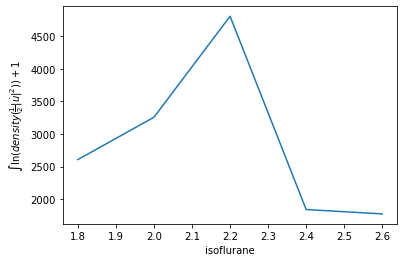

In [206]:
fig, ax = plt.subplots(1)
ax.plot(isoflurane, [np.sum(np.log(hist+1)) for hist in hists])
ax.set_xlabel("isoflurane")
ax.set_ylabel(r"$\int{\ln({density(\frac{1}{2}\left \| \dot{u} \right \|^{2})})+1}$")

In [171]:
np.sum(hists[4])

970197659

.....

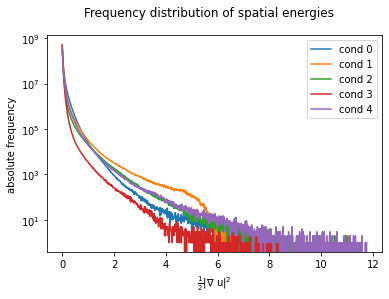

In [208]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "spatial_energy"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "spatial_energy"))
plot_frequencies(hists, bins, 
                 x_label=r"$\frac{1}{2}\left|\mathrm{\nabla\ u}\right|^2$",
                title= "Frequency distribution of spatial energies", logscale=True)

Text(0, 0.5, '$\\int{\\ln({density(\\frac{1}{2}\\left|\\mathrm{\\nabla\\ u}\\right|^2)})+1}$')

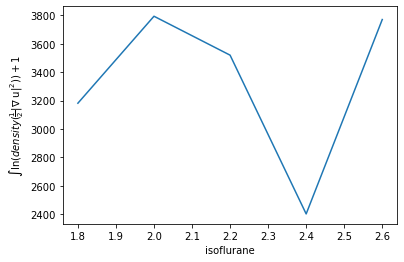

In [211]:
fig, ax = plt.subplots(1)
ax.plot(isoflurane, [np.sum(np.log(hist+1)) for hist in hists])
ax.set_xlabel("isoflurane")
ax.set_ylabel(r"$\int{\ln({density(\frac{1}{2}\left|\mathrm{\nabla\ u}\right|^2)})+1}$")

.....

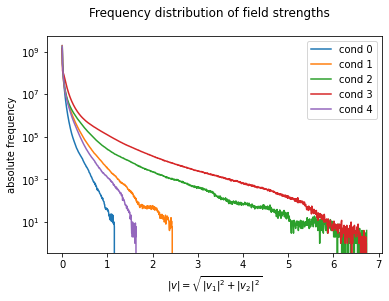

In [52]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "field_strengths"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "field_strengths"))
plot_frequencies(hists, bins, 
                 x_label=r"$\left|v\right|=\sqrt{\left|v_1\right|^2+\left|v_2\right|^2}$",
                title= "Frequency distribution of field strengths", logscale=True)

.....

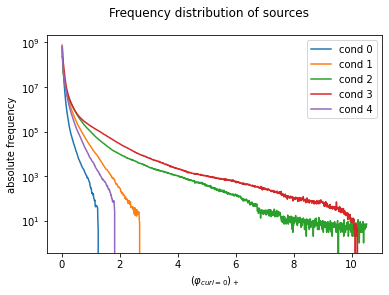

In [25]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "sources_frequency"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "sources_frequency"))
plot_frequencies(hists, -np.array(bins), 
                 x_label=r"$\left(\varphi_{curl=0}\right)_+$",
                title= "Frequency distribution of sources", logscale=True)

.....

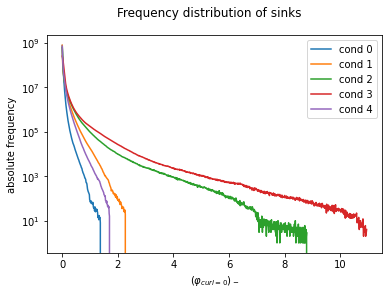

In [26]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "sinks_frequency"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "sinks_frequency"))
plot_frequencies(hists, np.array(bins), 
                 x_label=r"$\left(\varphi_{curl=0}\right)_- $",
                title= "Frequency distribution of sinks", logscale=True)

.....

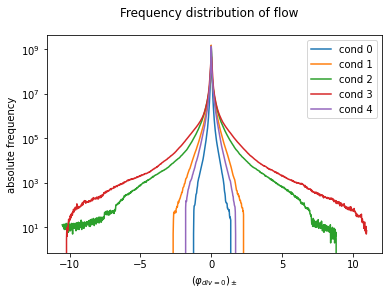

In [27]:
hists, names = load_files_in_folder(os.path.join(frequencies_folder, "flow_frequency"))
bins, names = load_files_in_folder(os.path.join(bin_boundaries_folder, "flow_frequency"))
plot_frequencies(hists, np.array(bins), 
                 x_label=r"$\left(\varphi_{div=0}\right)_\pm$",
                title= "Frequency distribution of flow", logscale=True)

In [233]:
names

['runstart13.npy',
 'runstart16.npy',
 'runstart20.npy',
 'runstart23.npy',
 'runstart26.npy']

Condition zero to 4 relate to (file-ID, isoflurane-level)

- runstart13: 	1.8

- runstart16:	2

- runstart20:	2.2

- runstart23:	2.4

- runstart26:	2.6


# Conclusion

For increasing levels of isoflurane higher intensities can be observed until a drop occurs for the last condition. Similarly derived measures show high values for higher levels of isoflurane other then the last condition.

A look at frequency spectrograms probably captures important differences, however, frequency analyis of slow-waves is an esteblished method that has been applied for slow-waves in flouroscence microscopy.